In [21]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
import matplotlib.pyplot as plt
from Data_definition import Data
from functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
T  = 600
dt = 0.01

t_span = (0, T)
t_eval = np.arange(*t_span, dt)

In [23]:
y_init = np.array([Data['initial_VS'], Data['initial_VD'],
                   Data['initial_w' ], Data['initial_n' ], Data['initial_h' ], Data['initial_c' ], Data['initial_q' ],
                   Data['initial_Ca']])


sol = scipy.integrate.solve_ivp(fun = lambda t, y: dydt(t, y, Data),
                                t_span = t_span,
                                y0 = y_init,
                                t_eval = t_eval,
                                method = 'RK45',
                                atol = 1e-6,
                                rtol = 1e-6,
                                vectorized=False)

if not sol.success:
    raise RuntimeError("ODE solver failed: " + sol.message)
else:
    print("ODE solver succeeded")

ODE solver succeeded


In [24]:
# Extract quantities of interest

time = sol.t

VS, VD, w, n, h, c, q, Ca = sol.y

IS, ID, IDS, INa, IK, ISL, ICa, IKC, IKAHP, IDL = \
    computeCurrents_vectorized(time, sol.y, Data)

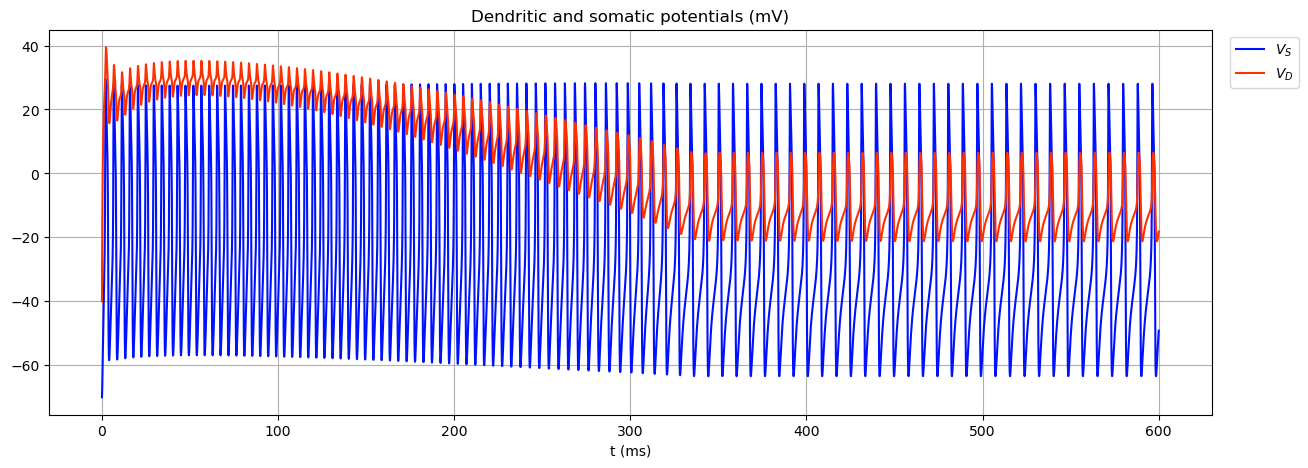

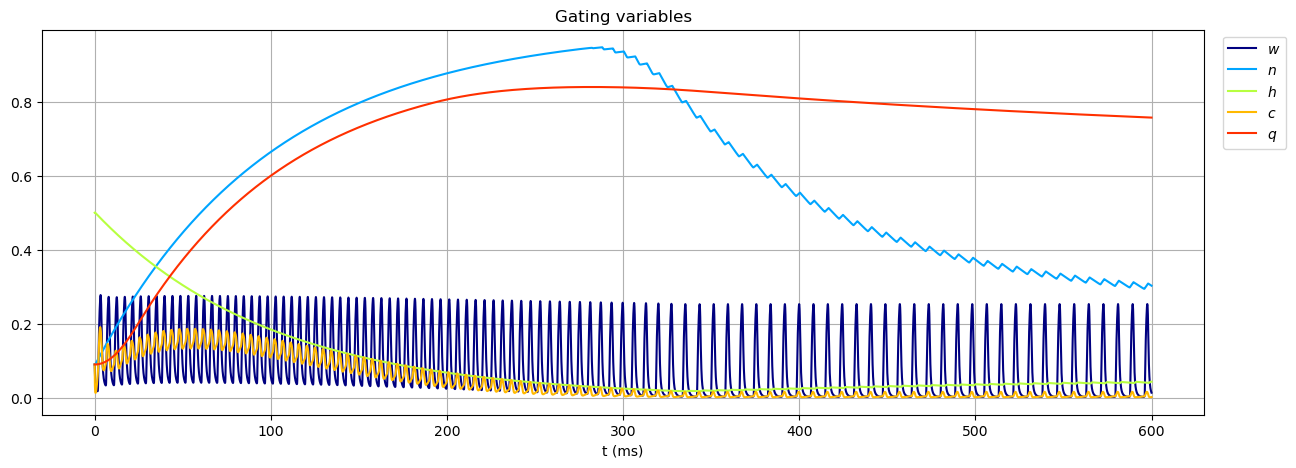

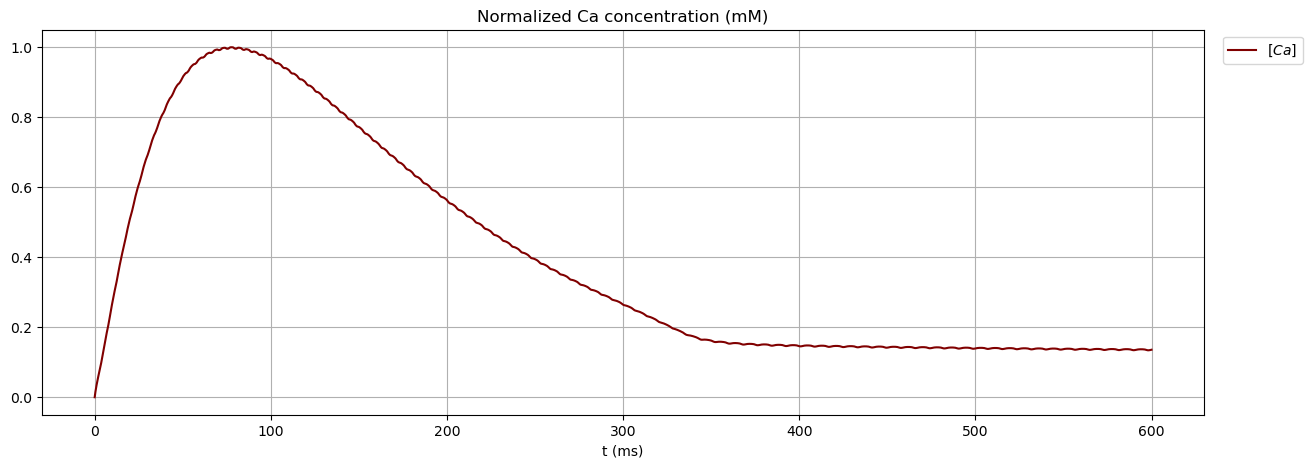

In [25]:
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1, 8))
figsize = (15, 5)

plt.figure(figsize=figsize)
plt.plot(time, VS, label='$V_S$', color=colors[1])
plt.plot(time, VD, label='$V_D$', color=colors[6])
plt.xlabel('t (ms)')
plt.title('Dendritic and somatic potentials (mV)')
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
plt.grid()
plt.show()

plt.figure(figsize=figsize)
plt.plot(time, w, label='$w$', color=colors[0])
plt.plot(time, n, label='$n$', color=colors[2])
plt.plot(time, h, label='$h$', color=colors[4])
plt.plot(time, c, label='$c$', color=colors[5])
plt.plot(time, q, label='$q$', color=colors[6])
plt.xlabel('t (ms)')
plt.title('Gating variables')
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
plt.grid()
plt.show()

plt.figure(figsize=figsize)
plt.plot(time, Ca/np.max(Ca), label='$[Ca]$', color=colors[7])
plt.xlabel('t (ms)')
plt.title('Normalized Ca concentration (mM)')
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
plt.grid()
plt.show()

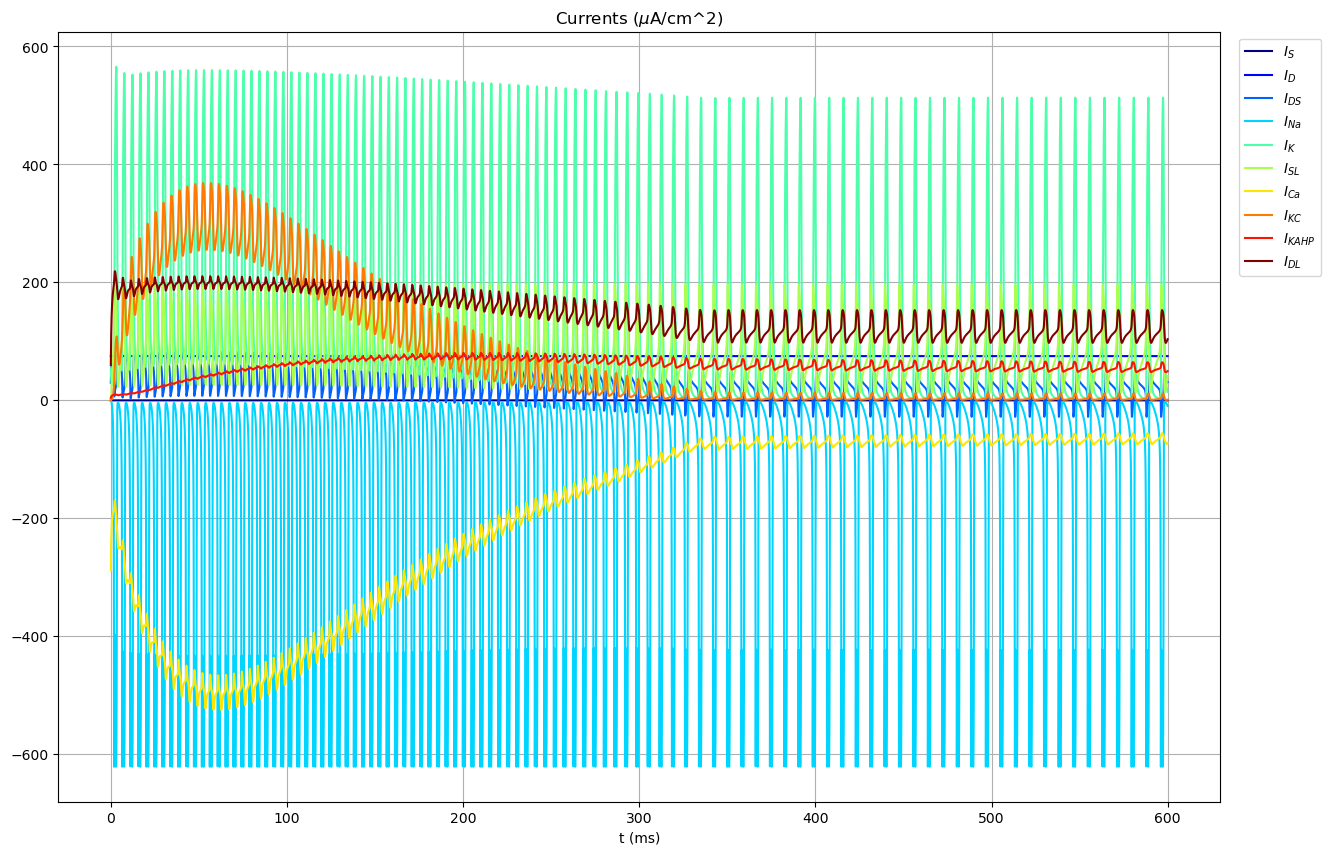

In [26]:
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1, 10))
figsize=(15, 10)

plt.figure(figsize=figsize)
plt.plot(time, IS   , label='$I_{S}$'   , color=colors[0])
plt.plot(time, ID   , label='$I_{D}$'   , color=colors[1])
plt.plot(time, IDS  , label='$I_{DS}$'  , color=colors[2])
plt.plot(time, INa  , label='$I_{Na}$'  , color=colors[3])
plt.plot(time, IK   , label='$I_{K}$'   , color=colors[4])
plt.plot(time, ISL  , label='$I_{SL}$'  , color=colors[5])
plt.plot(time, ICa  , label='$I_{Ca}$'  , color=colors[6])
plt.plot(time, IKC  , label='$I_{KC}$'  , color=colors[7])
plt.plot(time, IKAHP, label='$I_{KAHP}$', color=colors[8])
plt.plot(time, IDL  , label='$I_{DL}$'  , color=colors[9])
plt.xlabel('t (ms)')
plt.title(r'Currents ($\mu$A/cm^2)')
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
plt.grid()
# plt.ylim(-150, 150)
plt.show()

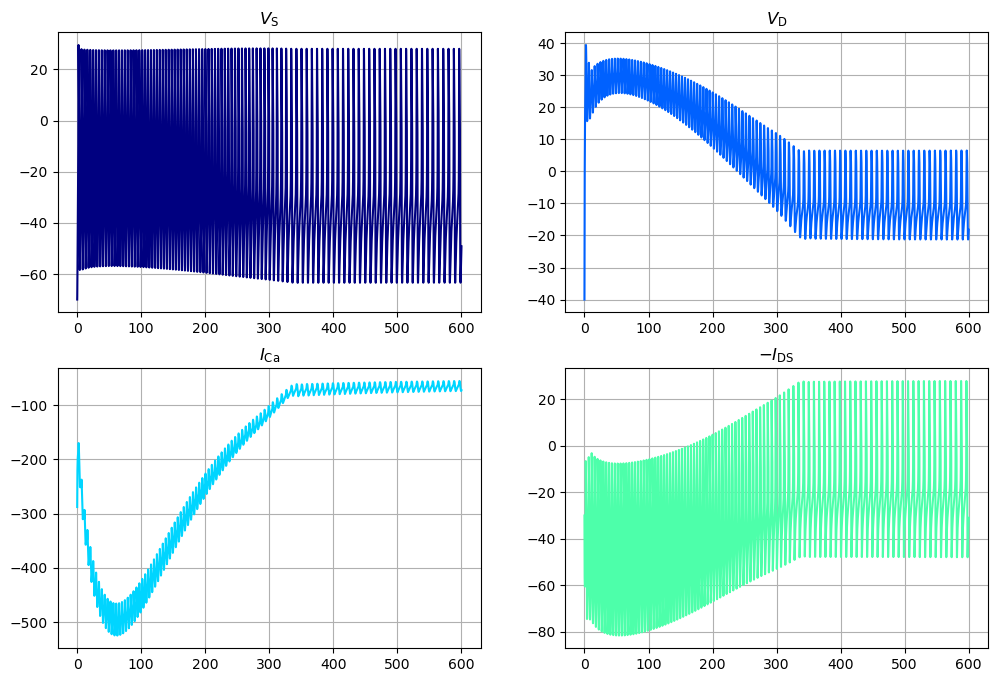

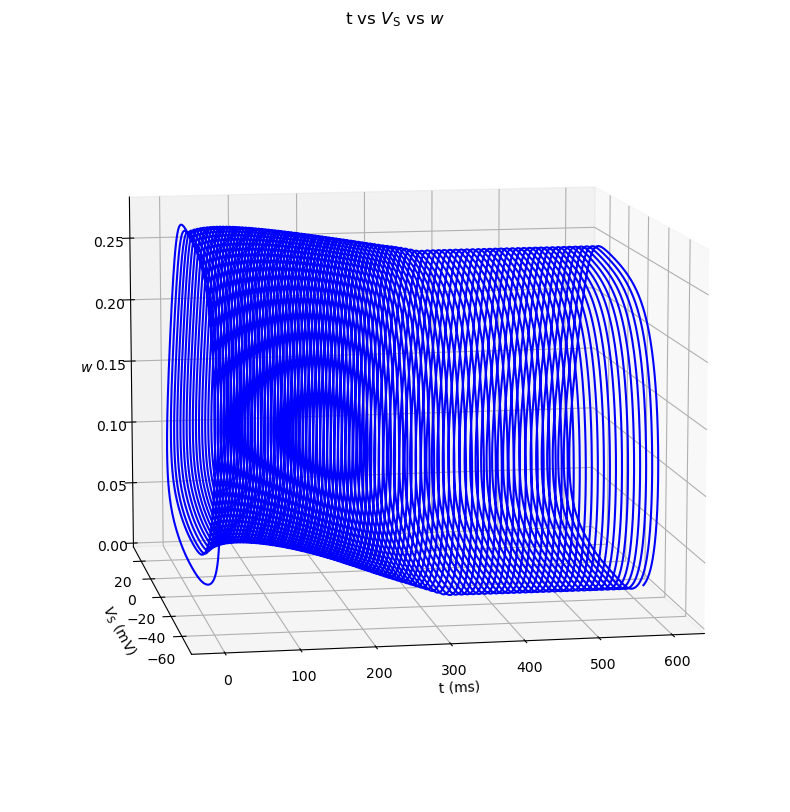

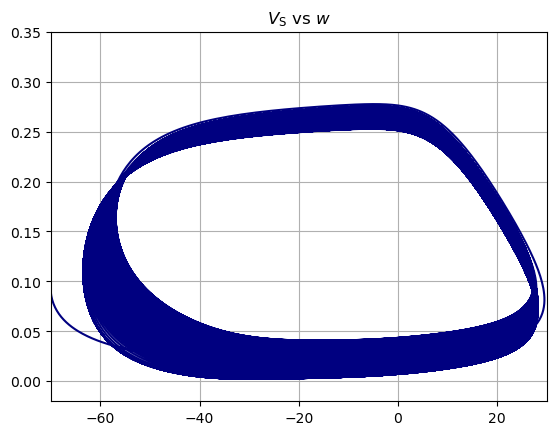

In [27]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(time, VS, color=colors[0])
plt.title('$V_\mathrm{S}$')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(time, VD, color=colors[2])
plt.title('$V_\mathrm{D}$')
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(time, ICa, color=colors[3])
plt.title('$I_{\mathrm{Ca}}$')
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(time, -IDS, color=colors[4])
plt.title('$-I_{\mathrm{DS}}$')
plt.grid()


fig = plt.figure(figsize=(18, 10)) 
ax = plt.axes(projection='3d')
ax.plot(time, VS, w, color=colors[1])
ax.view_init(10, 260)
plt.title("t vs $V_\mathrm{S}$ vs $w$")
ax.set_xlabel('t (ms)')
ax.set_ylabel('$V_\mathrm{S}$ (mV)')
ax.set_zlabel('$w$')
plt.grid()

plt.figure()
plt.plot(VS, w, color=colors[0])
plt.xlim(-70, 30)
plt.ylim(-0.02, 0.35)
plt.title("$V_\mathrm{S}$ vs $w$")
plt.grid()

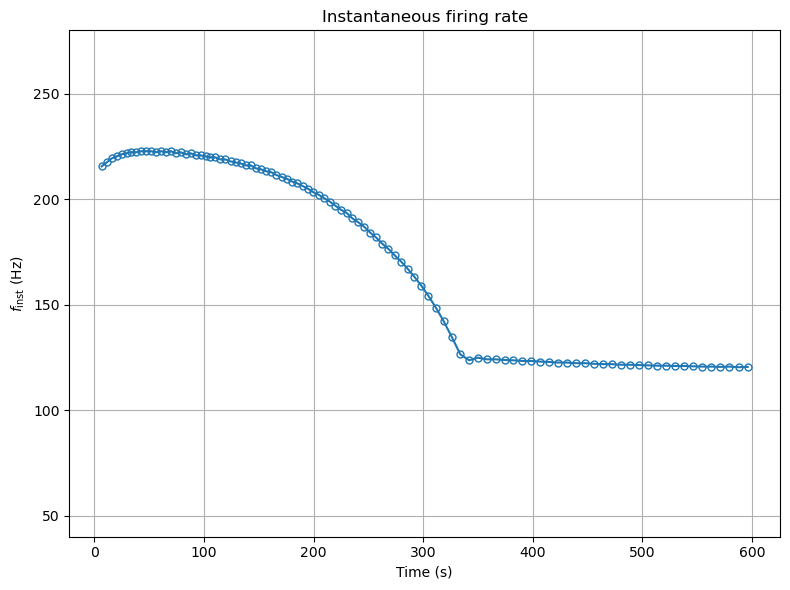

In [28]:
# Detect spikes
thresh = 20.0
spike_times = time[np.where((VS[:-1] < thresh) & (VS[1:] >= thresh))[0]]

# Compute instantaneous firing rate
inst_rate = 1e3 / np.diff(spike_times)
rate_times = spike_times[1:]

plt.figure(figsize=(8, 6))
plt.plot(rate_times, inst_rate, marker='o', fillstyle='none', markersize=5)
plt.xlabel('Time (s)')
plt.ylabel(r'$f_{\text{inst}}$ (Hz)')
plt.title('Instantaneous firing rate')
plt.tight_layout()
plt.ylim(40, 280)
plt.grid()
plt.show()

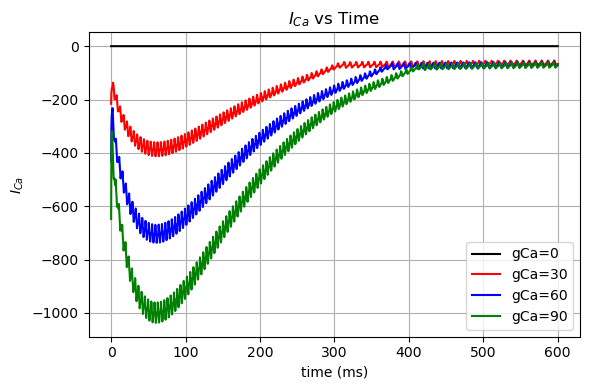

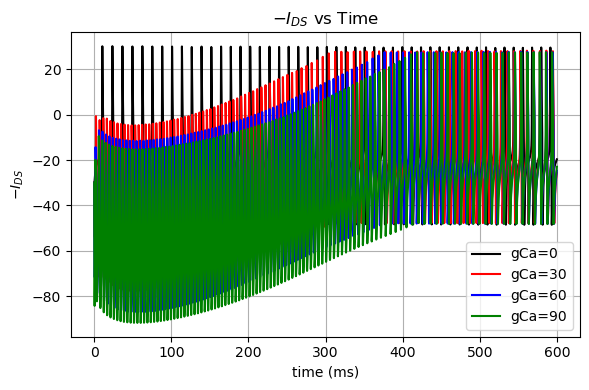

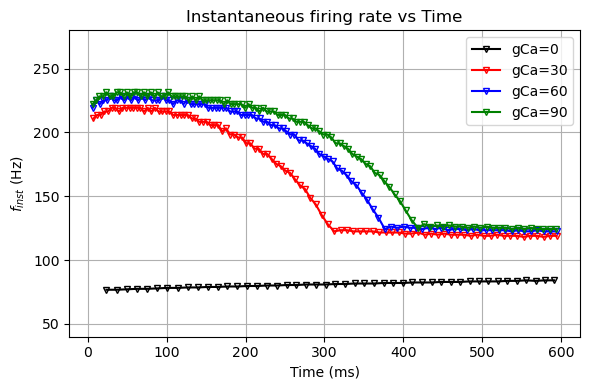

In [30]:
from Data_definition import Data

t_span = (0, 600)
t_eval = np.linspace(*t_span, 10000)
thresh = 20.0                               # Spike detection threshold (in mV)
gCa_values = [0, 30, 60, 90]
colors = ['black', 'red', 'blue', 'green']

# For combined plots
ICa_dict = {}
IDS_dict = {}
rate_times_dict = {}
inst_rate_dict = {}

for i, gCa in enumerate(gCa_values):
    Data.update({'gCa': gCa, 'IS': 0})

    y_init = np.array([Data['initial_VS'],
                       Data['initial_VD'],
                       Data['initial_w' ],
                       Data['initial_n' ],
                       Data['initial_h' ],
                       Data['initial_c' ],
                       Data['initial_q' ],
                       Data['initial_Ca']])

    sol = scipy.integrate.solve_ivp(fun = lambda t, y: dydt(t, y, Data),
                                    t_span = t_span,
                                    y0 = y_init,
                                    t_eval = t_eval,
                                    method = 'RK45',
                                    atol = 1e-6,
                                    rtol = 1e-6,
                                    vectorized=False)

    time = sol.t
    VS, VD, w, n, h, c, q, Ca = sol.y

    IS, ID, IDS, INa, IK, ISL, ICa, IKC, IKAHP, IDL = \
        computeCurrents_vectorized(time, sol.y, Data)
    
    # Spike detection via threshold crossing
    spike_idxs = np.where((VS[:-1] < thresh) & (VS[1:] >= thresh))[0]
    spike_times = time[spike_idxs]

    # Compute f_inst
    spike_times = time[np.where((VS[:-1] < thresh) & (VS[1:] >= thresh))[0]]

    # Store for combined plots
    ICa_dict[gCa] = ICa
    IDS_dict[gCa] = IDS
    rate_times_dict[gCa] = spike_times[1:]
    inst_rate_dict[gCa] = 1e3 / np.diff(spike_times)

# Combined ICa plot
plt.figure(figsize=(6, 4))
for i, gCa in enumerate(gCa_values):
    plt.plot(t_eval, ICa_dict[gCa], label=f'gCa={gCa}', color=colors[i])
plt.title('$I_{Ca}$ vs Time')
plt.xlabel('time (ms)')
plt.ylabel('$I_{Ca}$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Combined IDS plot
plt.figure(figsize=(6, 4))
for i, gCa in enumerate(gCa_values):
    plt.plot(t_eval, -IDS_dict[gCa], label=f'gCa={gCa}', color=colors[i])
plt.title('$-I_{DS}$ vs Time')
plt.xlabel('time (ms)')
plt.ylabel('$-I_{DS}$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Combined f_inst plot
plt.figure(figsize=(6, 4))
for i, gCa in enumerate(gCa_values):
    plt.plot(rate_times_dict[gCa], inst_rate_dict[gCa], label=f'gCa={gCa}',
             color=colors[i], marker='v', fillstyle='none', markersize=5)
plt.xlabel('Time (ms)')
plt.ylabel(r'$f_{inst}$ (Hz)')
plt.title('Instantaneous firing rate vs Time')
plt.ylim(40, 280)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()